In [1]:
# This code works in Python 3.10.6
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import torch_geometric.transforms as T
import networkx as nx
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
import csv
import os
import os.path as osp

Read DBLP dataset

In [3]:
df_nodes = pd.read_table(('node_pubmed.dat'),names=['node_id', 'node_name', 'node_type', 'node_attributes'],quoting=csv.QUOTE_NONE)
df_nodes

,node_id,node_name,node_type,node_attributes
0,0,ITCC,2,"0.02508,-0.036716,0.091492,-0.074665,0.022286,..."
1,1,gamma-Butyrolactone,2,"-0.072251,-0.1242,0.027377,-0.049692,0.022852,..."
2,2,eIF4E,0,"-0.85981,-1.632455,-0.238721,-0.527147,1.09448..."
3,3,abietane,2,"-0.100137,-0.295236,0.204746,-0.043928,0.09525..."
4,4,DOGMATISM,2,"0.005788,-0.080936,-0.038131,0.039531,-0.00082..."
...,...,...,...,...
63104,63104,archival_tumor,1,"0.066291,0.020142,0.146529,-0.058354,0.11038,0..."
63105,63105,diflucortolone,2,"0.027386,-0.231205,0.110102,0.058394,-0.052956..."
63106,63106,A2BP1,0,"0.038467,-0.022038,0.046468,-0.087253,0.157027..."
63107,63107,Digital_Health_Literacy,1,"-0.01894,-0.061136,0.097672,-0.102349,0.078652..."


In [4]:
df_labels_train = pd.read_table(('label_pubmed.dat'),names=['node_id', 'node_name', 'node_type', 'node_label'])
df_labels_train

,node_id,node_name,node_type,node_label
0,46178,psoriasis,1,6
1,60275,Skin_disease,1,6
2,16406,Nevus,1,6
3,52160,frambesia,1,6
4,46120,Erythroderma,1,6
...,...,...,...,...
363,55492,Trematode,1,1
364,33145,malformation,1,1
365,30135,hypoparathyroidism,1,1
366,719,Hyperparathyroidism,1,1


In [5]:
df_labels_test = pd.read_table(('label_pubmed.dat.test'),names=['node_id', 'node_name', 'node_type', 'node_label'])
df_labels_test

,node_id,node_name,node_type,node_label
0,60572,Keratosis,1,6
1,15604,comedones,1,6
2,58988,scleredema,1,6
3,46537,erythroderma,1,6
4,33425,Seborrheic_dermatitis,1,6
...,...,...,...,...
81,18593,Thyrotoxicosis,1,1
82,8604,Adenopathy,1,1
83,61782,hip,1,1
84,46434,tearing,1,1


In [6]:
df_labels = pd.concat([df_labels_train, df_labels_test],ignore_index=True)
df_labels

,node_id,node_name,node_type,node_label
0,46178,psoriasis,1,6
1,60275,Skin_disease,1,6
2,16406,Nevus,1,6
3,52160,frambesia,1,6
4,46120,Erythroderma,1,6
...,...,...,...,...
449,18593,Thyrotoxicosis,1,1
450,8604,Adenopathy,1,1
451,61782,hip,1,1
452,46434,tearing,1,1


In [7]:
df_gene = df_nodes[df_nodes['node_type'] == 0]
df_gene.reset_index()

,index,node_id,node_name,node_type,node_attributes
0,2,2,eIF4E,0,"-0.85981,-1.632455,-0.238721,-0.527147,1.09448..."
1,5,5,UBLCP1,0,"-0.116854,-0.120575,0.07072,-0.166677,0.106602..."
2,6,6,nodZ,0,"-0.042955,-0.014979,0.023987,0.025399,0.013668..."
3,11,11,grp170,0,"-0.106744,-0.079176,-0.107495,0.049958,-0.0039..."
4,12,12,B6_and_D2,0,"-0.097067,-0.050246,0.000982,0.024265,0.025848..."
...,...,...,...,...,...
13556,63090,63090,hCGalpha,0,"-0.189161,-0.110873,0.018683,0.030247,0.08659,..."
13557,63093,63093,HSD2,0,"-0.03078,-0.16347,0.081172,0.023949,0.05953,-0..."
13558,63099,63099,pgi1,0,"-0.021245,-0.040226,0.059328,-0.154712,-0.0274..."
13559,63103,63103,cytotoxic_T-lymphocyte_antigen-4,0,"-0.027838,-0.221384,0.031655,0.041904,0.094765..."


In [8]:
df_chemical = df_nodes[df_nodes['node_type'] == 2]
df_chemical.reset_index()

,index,node_id,node_name,node_type,node_attributes
0,0,0,ITCC,2,"0.02508,-0.036716,0.091492,-0.074665,0.022286,..."
1,1,1,gamma-Butyrolactone,2,"-0.072251,-0.1242,0.027377,-0.049692,0.022852,..."
2,3,3,abietane,2,"-0.100137,-0.295236,0.204746,-0.043928,0.09525..."
3,4,4,DOGMATISM,2,"0.005788,-0.080936,-0.038131,0.039531,-0.00082..."
4,7,7,TZDs,2,"-0.383792,-0.101718,-0.271882,-0.411151,0.1531..."
...,...,...,...,...,...
26517,63100,63100,Dibutyryl_cyclic_AMP,2,"-0.01441,-0.2465,-0.061486,-0.11033,-0.050258,..."
26518,63101,63101,Ag3Sn,2,"0.062272,0.027182,-0.130906,-0.13105,-0.049692..."
26519,63102,63102,PAL-LPC,2,"-0.017939,0.004023,0.050958,-0.115518,-0.12366..."
26520,63105,63105,diflucortolone,2,"0.027386,-0.231205,0.110102,0.058394,-0.052956..."


In [9]:
df_species = df_nodes[df_nodes['node_type'] == 3]
df_species.reset_index()

,index,node_id,node_name,node_type,node_attributes
0,16,16,painted_turtles,3,"-0.095541,-0.209068,-0.167771,0.081688,0.23290..."
1,30,30,Rickettsia_rickettsii,3,"0.030015,-0.184471,0.088601,-0.097601,-0.07233..."
2,52,52,Ictalurus_punctatus,3,"-0.093925,-0.211232,0.173214,0.096446,-0.06752..."
3,128,128,N._GONORRHOEAE,3,"-0.014923,-0.060145,0.014826,-0.00509,0.009751..."
4,140,140,giraffes,3,"-0.174262,0.005391,0.191771,0.075813,0.00924,-..."
...,...,...,...,...,...
2858,62965,62965,Methanospirillum_hungatei,3,"0.019382,-0.09156,0.09262,-0.020885,-0.007555,..."
2859,62977,62977,H._pylori,3,"2.070796,-0.284317,2.720454,-0.739623,-1.43600..."
2860,62998,62998,F_nucleatum,3,"-0.026027,-0.116689,0.046049,-0.065215,-0.0877..."
2861,63031,63031,H._pylori_strain,3,"-0.024642,-0.024474,0.113648,-0.044572,-0.1329..."


Training data for GMM 

In [10]:
#Original disease node features
#Select the nodes of type 1 which are labeled
df_disease=pd.merge(df_nodes, df_labels, on="node_id")[['node_id','node_attributes','node_label']]
df_disease = df_disease.reset_index()
df_disease

,index,node_id,node_attributes,node_label
0,0,81,"0.293945,-1.118894,0.365789,0.826958,-1.024909...",2
1,1,382,"-0.076263,-0.1012,0.205599,-0.010939,0.011885,...",0
2,2,719,"-0.00509,-0.093002,0.155948,-1.041911,-0.11497...",1
3,3,1168,"-1.590567,-1.421712,1.546614,2.070439,-1.26965...",5
4,4,1183,"-0.047317,-0.141594,0.075213,-0.12674,-0.05318...",4
...,...,...,...,...
449,449,62712,"0.167095,-0.445305,0.003027,-0.286198,0.293009...",0
450,450,62883,"-0.8007,0.467567,-0.670862,-0.588446,-0.42748,...",0
451,451,62907,"0.02855,-0.412978,0.205488,-0.129589,-0.13769,...",4
452,452,62954,"0.865129,-0.039594,-0.652221,0.421712,-0.16300...",1


Fit GMM to 8 disease types

In [11]:
def convert_string_to_float(df):
    return df['node_attributes'].apply(lambda x: np.fromstring(x, dtype=float, sep=',' ))

In [12]:
def preprocess_class(df_class):
    df_class = df_class.reset_index()
    df_class = convert_string_to_float(df_class)

    x = torch.tensor(df_class).float()
    disease_class = pd.DataFrame(x.numpy())
    return disease_class

In [13]:
class0 = df_disease[df_disease['node_label'] == 0].drop(['node_label','node_id'], axis = 1)
disease_class0 = preprocess_class(class0)
disease_class0.shape

(69, 200)

In [14]:
class1 = df_disease[df_disease['node_label'] == 1].drop(['node_label','node_id'], axis = 1)
disease_class1 = preprocess_class(class1)
disease_class1.shape

(52, 200)

In [15]:
class2 = df_disease[df_disease['node_label'] == 2].drop(['node_label','node_id'], axis = 1)
disease_class2 = preprocess_class(class2)
disease_class2.shape

(48, 200)

In [16]:
class3 = df_disease[df_disease['node_label'] == 3].drop(['node_label','node_id'], axis = 1)
disease_class3 = preprocess_class(class3)
disease_class3.shape

(39, 200)

In [17]:
class4 = df_disease[df_disease['node_label'] == 4].drop(['node_label','node_id'], axis = 1)
disease_class4 = preprocess_class(class4)
disease_class4.shape

(98, 200)

In [18]:
class5 = df_disease[df_disease['node_label'] == 5].drop(['node_label','node_id'], axis = 1)
disease_class5 = preprocess_class(class5)
disease_class5.shape

(64, 200)

In [19]:
class6 = df_disease[df_disease['node_label'] == 6].drop(['node_label','node_id'], axis = 1)
disease_class6 = preprocess_class(class6)
disease_class6.shape

(42, 200)

In [20]:
class7 = df_disease[df_disease['node_label'] == 7].drop(['node_label','node_id'], axis = 1)
disease_class7 = preprocess_class(class7)
disease_class7.shape

(42, 200)

In [21]:
gene = preprocess_class(df_gene)
gene.shape

(13561, 200)

In [22]:
chemical = preprocess_class(df_chemical)
chemical.shape

(26522, 200)

In [23]:
species = preprocess_class(df_species)
species.shape

(2863, 200)

Fit and sample GMM

In [24]:
new_features_dict = {}

In [25]:
def sample_features(model,node_type, n_samples):

    smpls = model.sample(n_samples)
    print("no of class {} node samples - {}".format(node_type, n_samples))
    return smpls[0]

In [26]:
def fit_sample_gm(df_class, node_type, n_samples):
    #fit
    model = GaussianMixture(n_components=1, covariance_type='full', random_state = 0)
    model.fit(df_class)
    #print("Mean for nodetype", node_type,model.means_)
    #sample
    smpls = sample_features(model, node_type, n_samples)
    new_features_dict[node_type] = smpls

Class 0 - GENE,

Class 1 - DISEASE,

Class 2  - CHEMICAL,

Class 3 - SPECIES

In [27]:
G = nx.read_gexf("PubMed_hgen.gexf")
n_samples_disease = len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 1))
n_samples_gene = len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 0))
n_samples_chemical = len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 2))
n_samples_species = len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 3))

In [28]:
len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 1))

643

In [29]:
len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 0))

313

In [30]:
len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 2))

564

In [31]:
len(dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 3))

45

In [32]:
#sample disease classes

In [33]:
fit_sample_gm(disease_class0, 'disease0', 80)

no of class disease0 node samples - 80


In [34]:
fit_sample_gm(disease_class1, 'disease1', 80)

no of class disease1 node samples - 80


In [35]:
fit_sample_gm(disease_class2, 'disease2', 80)

no of class disease2 node samples - 80


In [36]:
fit_sample_gm(disease_class3, 'disease3', 80)

no of class disease3 node samples - 80


In [37]:
fit_sample_gm(disease_class4, 'disease4', 80)

no of class disease4 node samples - 80


In [38]:
fit_sample_gm(disease_class5, 'disease5', 81)

no of class disease5 node samples - 81


In [39]:
fit_sample_gm(disease_class6, 'disease6', 81)

no of class disease6 node samples - 81


In [40]:
fit_sample_gm(disease_class7, 'disease7', 81)

no of class disease7 node samples - 81


In [41]:
#sample gene class

In [42]:
fit_sample_gm(gene, 'gene', n_samples_gene)

no of class gene node samples - 313


In [43]:
#sample chemical class

In [44]:
fit_sample_gm(gene, 'chemical', n_samples_chemical)

no of class chemical node samples - 564


In [45]:
#sample species class

In [46]:
fit_sample_gm(gene, 'species', n_samples_species)

no of class species node samples - 45


Plot node feature distributions

In [47]:
new_features_dict

{'disease0': array([[ 0.08627073, -0.59319872,  0.48172278, ..., -0.67872658,
         -1.00027569,  0.76401648],
        [ 0.70725825,  0.13961589,  0.28047035, ..., -0.22698717,
         -0.33279937,  0.01892775],
        [-0.02457247, -0.15107352, -1.18492558, ...,  0.2353572 ,
         -0.13065053,  0.81432058],
        ...,
        [-0.01852915, -0.44594497, -0.17008841, ...,  0.06580165,
         -0.00629215, -0.90806522],
        [-0.52182464, -0.57383883,  0.12439287, ..., -0.82863857,
         -0.14461336, -0.01780792],
        [-0.17381819,  0.13848542, -0.15039488, ..., -0.4089903 ,
          0.03979484, -0.39933179]]),
 'disease1': array([[-0.95306843, -0.31776091, -0.93878948, ...,  1.2777683 ,
         -0.97224789, -0.2152814 ],
        [-0.97029081, -0.50659134, -0.63937956, ...,  0.66232629,
         -1.05180674, -1.1754348 ],
        [-0.74174563, -0.36057994,  0.02495897, ...,  1.60338697,
          0.06190127,  0.19066482],
        ...,
        [-0.57960057, -0.38267

In [48]:
def plot_dist(node_list0,node_list1,node_list2,node_list3,node_list4,node_list5,node_list6,node_list7):    

    fig, ax = plt.subplots(figsize=(7, 5))

    sns.distplot(node_list0, label='disease 0', ax=ax , hist= False)
    sns.distplot(node_list1, label='disease 1', ax=ax , hist= False)
    sns.distplot(node_list2, label='disease 2', ax=ax , hist= False)
    sns.distplot(node_list3, label='disease 3', ax=ax , hist= False)
    sns.distplot(node_list4, label='disease 4', ax=ax , hist= False)
    sns.distplot(node_list5, label='disease 5', ax=ax , hist= False)
    sns.distplot(node_list6, label='disease 6', ax=ax , hist= False)
    sns.distplot(node_list7, label='disease 7', ax=ax , hist= False)

    ax.set_title('Dist plots')
    ax.legend()
    plt.show()

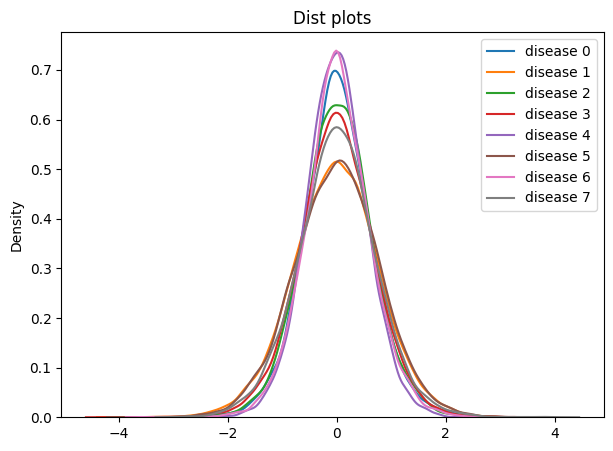

In [49]:
#Normal Distributions of 8 node types after fitting Gaussian Mixture Models 
plot_dist(new_features_dict['disease0'],new_features_dict['disease1'],
          new_features_dict['disease2'],new_features_dict['disease3'],
         new_features_dict['disease4'],new_features_dict['disease5'],
          new_features_dict['disease6'],new_features_dict['disease7'])

In [51]:
disease0_sampled = pd.DataFrame(new_features_dict['disease0'])
disease0_sampled['class'] = 0
disease0_sampled.shape

(80, 201)

In [52]:
disease1_sampled = pd.DataFrame(new_features_dict['disease1'])
disease1_sampled['class'] = 1
disease1_sampled.shape

(80, 201)

In [53]:
disease2_sampled = pd.DataFrame(new_features_dict['disease2'])
disease2_sampled['class'] = 2
disease2_sampled.shape

(80, 201)

In [54]:
disease3_sampled = pd.DataFrame(new_features_dict['disease3'])
disease3_sampled['class'] = 3
disease3_sampled.shape

(80, 201)

In [55]:
disease4_sampled = pd.DataFrame(new_features_dict['disease4'])
disease4_sampled['class'] = 4
disease4_sampled.shape

(80, 201)

In [56]:
disease5_sampled = pd.DataFrame(new_features_dict['disease5'])
disease5_sampled['class'] = 5
disease5_sampled.shape

(81, 201)

In [57]:
disease6_sampled = pd.DataFrame(new_features_dict['disease6'])
disease6_sampled['class'] = 6
disease6_sampled.shape

(81, 201)

In [58]:
disease7_sampled = pd.DataFrame(new_features_dict['disease7'])
disease7_sampled['class'] = 7
disease7_sampled.shape

(81, 201)

In [59]:
gene_sampled = pd.DataFrame(new_features_dict['gene'])
gene_sampled.shape

(313, 200)

In [60]:
chemical_sampled = pd.DataFrame(new_features_dict['chemical'])
chemical_sampled.shape

(564, 200)

In [61]:
species_sampled = pd.DataFrame(new_features_dict['species'])
species_sampled.shape

(45, 200)

In [62]:
#Disease

In [63]:
disease_node_features = pd.concat([disease0_sampled,disease1_sampled,disease2_sampled,
                                  disease3_sampled,disease4_sampled,disease5_sampled,
                                   disease6_sampled,disease7_sampled],ignore_index=True)

In [64]:
class1_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 1)
disease_nodeids = [int(x) for x in list(class1_node_subset.keys())]
disease_node_features.insert(0,'nodeId',disease_nodeids)
disease_node_features.shape

(643, 202)

In [65]:
#Gene

In [66]:
gene_node_features = pd.DataFrame(new_features_dict['gene'])

In [67]:
class0_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 0)
gene_nodeids = [int(x) for x in list(class0_node_subset.keys())]
gene_node_features.insert(0,'nodeId',gene_nodeids)
gene_node_features.shape

(313, 201)

In [68]:
#Chemical

In [69]:
chemical_node_features = pd.DataFrame(new_features_dict['chemical'])

In [70]:
class2_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 2)
chemical_nodeids = [int(x) for x in list(class2_node_subset.keys())]
chemical_node_features.insert(0,'nodeId',chemical_nodeids)
chemical_node_features.shape

(564, 201)

In [71]:
#Species

In [72]:
species_node_features = pd.DataFrame(new_features_dict['species'])

In [73]:
class3_node_subset = dict((n,d['class']) for n,d in G.nodes().items() if d['class'] == 3)
species_nodeids = [int(x) for x in list(class3_node_subset.keys())]
species_node_features.insert(0,'nodeId',species_nodeids)
species_node_features.shape

(45, 201)